In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from scipy.special import logit

import sys
sys.path.append('../../python/example/berry')
import util
import fast_inla
import berry
import quadrature

/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
N = int(1e2)
n_i = np.tile(np.array([20, 20, 35, 35]), (N, 1))
y_i = np.tile(np.array([0, 1, 9, 10], dtype=np.float64), (N, 1))
data = np.stack((y_i, n_i), axis=2)
fi = fast_inla.FastINLA()
sigma2_post, _, theta_mu, theta_sigma = fi.numpy_inference(y_i, n_i)
correct = np.array(
    [
        1.25954474e02,
        4.52520893e02,
        8.66625278e02,
        5.08333300e02,
        1.30365045e02,
        2.20403048e01,
        3.15183578e00,
        5.50967224e-01,
        2.68365061e-01,
        1.23585852e-01,
        1.13330444e-02,
        5.94800210e-04,
        4.01075571e-05,
        4.92782335e-06,
        1.41605356e-06,
    ]
)
np.testing.assert_allclose(sigma2_post[0], correct, rtol=1e-3)

In [4]:
n_arms = 2
fi = fast_inla.FastINLA(n_arms=n_arms, sigma2_n=90)
b = berry.Berry(n_arms=n_arms, sigma2_bounds=(1e-6, 1e3))

n_i = np.full((N, n_arms), 35)
y_i = np.full_like(n_i, 5)
data = np.stack((y_i, n_i), axis=-1)
sigma2_post, _, theta_mu, theta_sigma = fi.numpy_inference(y_i, n_i)

In [5]:
n_arms = 2
ys = np.arange(0, 10)
Y1, Y2 = np.meshgrid(ys, ys)
y_i = np.stack((Y1.ravel(), Y2.ravel()), axis=-1)
n_i = np.full_like(y_i, 35)
data = np.stack((y_i, n_i), axis=-1)
sigma2_post, _, theta_mu, theta_sigma = fi.numpy_inference(y_i, n_i)

y= [8 4]


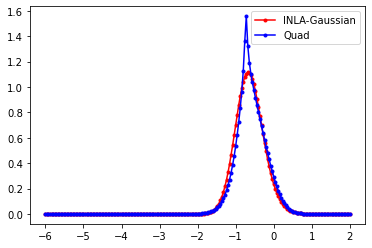

y= [4 8]


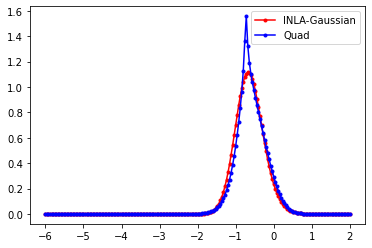

In [6]:
for arm_idx, plot_idx in [(0, 48), (1, 84)]:
    ti_N = 201
    ti_rule = util.simpson_rule(ti_N, -6.0, 2.0)
    print('y=', data[plot_idx,:,0])

    # quadrature marginal
    integrate_dims = list(range(n_arms))
    integrate_dims.remove(arm_idx)
    quad_p_ti_g_y = quadrature.integrate(
        b,
        data[
            plot_idx:(plot_idx + 1),
        ],
        integrate_sigma2=True,
        integrate_thetas=integrate_dims,
        fixed_dims={arm_idx: ti_rule},
        n_arms=n_arms,
        n_theta=15,
    )
    quad_p_ti_g_y /= np.sum(quad_p_ti_g_y * ti_rule.wts, axis=1)[:, None]

    # INLA marginal
    gaussian_pdf = scipy.stats.norm.pdf(
        ti_rule.pts[:, None],
        theta_mu[plot_idx, :, arm_idx],
        theta_sigma[plot_idx, :, arm_idx],
    )
    gaussian_p_ti_g_y = np.sum(
        gaussian_pdf * sigma2_post[plot_idx] * fi.sigma2_rule.wts[None, :], axis=1
    )

    plt.plot(ti_rule.pts, gaussian_p_ti_g_y, "r-o", markersize=3, label="INLA-Gaussian")
    plt.plot(ti_rule.pts, quad_p_ti_g_y[0], "b-o", markersize=3, label="Quad")
    plt.legend()
    plt.show()

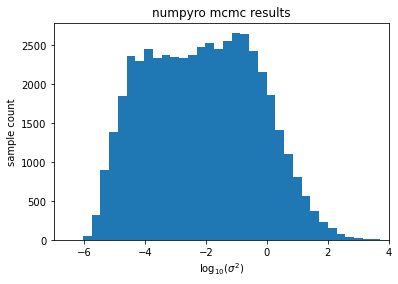

In [66]:
import mcmc

results_mcmc = mcmc.mcmc_berry(
    data[plot_idx : (plot_idx + 1)],
    b.logit_p1,
    b.suc_thresh,
    n_arms=n_arms,
    dtype=np.float64,
    n_samples=50000
)

sigma2_mcmc = results_mcmc["x"][0]["sigma2"][0]
plt.title("numpyro mcmc results")
plt.hist(np.log10(sigma2_mcmc.to_py()), bins=40)
plt.xlabel("$\log_{10} (\sigma^2)$")
plt.ylabel("sample count")
plt.xlim([-7, 4])
plt.show()


In [67]:
mcmc_cdf = (sigma2_mcmc[None, :] < b.sigma2_rule.pts[:, None]).sum(axis=1)
mcmc_pdf = np.zeros(b.sigma2_rule.pts.shape[0])
mcmc_pdf[1:] = (mcmc_cdf[1:] - mcmc_cdf[:-1]) / sigma2_mcmc.shape[0]

y= [4 8]


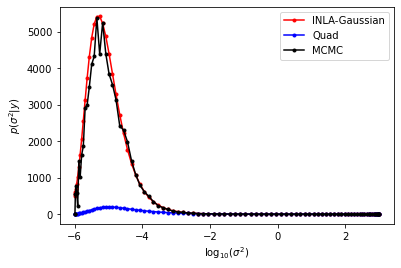

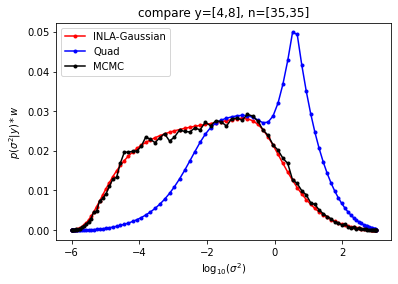

In [69]:
for arm_idx, plot_idx in [(1, 84)]:
    print('y=', data[plot_idx,:,0])

    # quadrature marginal
    integrate_dims = list(range(n_arms))
    # integrate_dims.remove(arm_idx)
    quad_p_s2_g_y = quadrature.integrate(
        b,
        data[
            plot_idx:(plot_idx + 1),
        ],
        integrate_sigma2=False,
        integrate_thetas=integrate_dims,
        n_arms=n_arms,
        n_theta=15,
    )
    quad_p_s2_g_y /= np.sum(quad_p_s2_g_y * b.sigma2_rule.wts, axis=1)

    plt.plot(np.log10(b.sigma2_rule.pts), sigma2_post[plot_idx], "r-o", markersize=3, label="INLA-Gaussian")
    plt.plot(np.log10(b.sigma2_rule.pts), quad_p_s2_g_y[0], "b-o", markersize=3, label="Quad")
    plt.plot(np.log10(b.sigma2_rule.pts), mcmc_pdf / b.sigma2_rule.wts, "k-o", markersize=3, label="MCMC")
    plt.xlabel('$\log_{10} (\sigma^2)$')
    plt.ylabel('$p(\sigma^2 | y)$')
    plt.legend()
    plt.show()

    plt.plot(np.log10(b.sigma2_rule.pts), sigma2_post[plot_idx] * b.sigma2_rule.wts, "r-o", markersize=3, label="INLA-Gaussian")
    plt.title('compare y=[4,8], n=[35,35]')
    plt.plot(np.log10(b.sigma2_rule.pts), quad_p_s2_g_y[0] * b.sigma2_rule.wts, "b-o", markersize=3, label="Quad")
    plt.plot(np.log10(b.sigma2_rule.pts), mcmc_pdf, "k-o", markersize=3, label="MCMC")
    plt.legend()
    plt.xlabel('$\log_{10} (\sigma^2)$')
    plt.ylabel('$p(\sigma^2 | y) * w$')
    plt.show()